## source ; https://towardsdatascience.com/factorization-machines-for-item-recommendation-with-implicit-feedback-data-5655a7c749db

## source code ; https://github.com/etlundquist/rankfm/blob/master/examples/instacart.ipynb

I will use 'rankfm' library 

__RankFM is a python implementation of the general Factorization Machines model class adapted for collaborative filtering recommendation/ranking problems with implicit feedback user/item interaction data. It uses Bayesian Personalized Ranking (BPR) and a variant of Weighted Approximate-Rank Pairwise (WARP) loss to learn model weights via Stochastic Gradient Descent (SGD). It can (optionally) incorporate sample weights and user/item auxiliary features to augment the main interaction data.__

__It has just two columns: a user_id and an item_id (you can name these fields whatever you want or use a numpy array instead). Notice that there is no rating column - this library is for implicit feedback data (e.g. watches, page views, purchases, clicks) as opposed to explicit feedback data (e.g. 1-5 ratings, thumbs up/down). Implicit feedback is far more common in real-world recommendation contexts and doesn't suffer from the missing-not-at-random problem of pure explicit feedback approaches.__

a lot , concrertly explanation about 'Rankfm' is here
; https://github.com/etlundquist/rankfm

#### Implict Feedback 

__ALS algorithm__

 this approach has a few key drawbacks. 
 
 First, by representing the data as a matrix of user/item interactions it is not possible to include auxiliary features, such as the user/item attributes used in CBF models and/or other __contextual information about the interaction itself.__ This 
 
 is a major lost opportunity when rich auxiliary features exist, and also prevents the model from generating informative predictions for new users/items, often referred to as the Cold-Start Problem. 
 
 Second, encoding user implicit feedback as binary (0, 1) ratings and minimizing the model’s prediction error is a __very indirect representation of user preferences__ — you don’t know for sure that the unobserved items actually are negative for 
 
 the user, and certainly some positive (and negative) items are preferred more than others with the exact same encoded (0, 1) rating.

#### Factorization Machine

Factorization Machines (FM) are generic supervised learning models that map arbitrary real-valued features into a low-dimensional latent factor space and can be applied naturally to a wide variety of prediction tasks including regression, 

classification, and ranking.

Unlike the classic MF model discussed above which inputs a user-item interaction matrix, FM models represent user-item interactions as tuples of real-valued feature vectors and numeric target variables — this data format should be familiar to 

anyone who’s ever trained a standard regression or classification model.

__FMs instead use factorized interaction parameters: feature interaction weights are represented as the inner product of the two features’ latent factor space embeddings:__

##### Basis Procedure

1. Randomly sample an unobserved item for the user and compute its utility score. If the unobserved item’s score exceeds the observed item’s score plus a fixed margin then make a gradient update, otherwise continue to sample negative items

2. Scale the magnitude of the gradient update based on the number of negative items sampled before finding a margin violation — make smaller updates if more negative items were sampled as it’s more likely the model is currently ranking user preferences correctly

##### Import Required Packages and Set options

###### Import Base Libraries

In [3]:
import os
import sys
import random

import numpy as np
import numba as nb
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.3f}'.format)

sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Prepare Example Data

##### Load Departments Data

In [5]:
departments_df = pd.read_csv("dataset/instacart_2017_05_01/departments.csv")
departments_df['department_id'] = departments_df['department_id'].astype(np.uint8)
departments_df.info()
departments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     uint8 
 1   department     21 non-null     object
dtypes: object(1), uint8(1)
memory usage: 317.0+ bytes


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


##### Load Aisles Data

In [6]:
aisles_df = pd.read_csv('dataset/instacart_2017_05_01/aisles.csv')
aisles_df['aisle_id'] = aisles_df['aisle_id'].astype(np.uint8)
aisles_df.info()
aisles_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    uint8 
 1   aisle     134 non-null    object
dtypes: object(1), uint8(1)
memory usage: 1.3+ KB


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


##### Load Products Data

In [7]:
products_dtypes = {
    'product_id': np.int32, 
    'product_name': str, 
    'aisle_id': np.uint8, 
    'department_id': np.uint8
}

In [8]:
products_df = pd.read_csv('dataset/instacart_2017_05_01/products.csv', dtype=products_dtypes)
products_df.info()
products_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int32 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  uint8 
 3   department_id  49688 non-null  uint8 
dtypes: int32(1), object(1), uint8(2)
memory usage: 679.5+ KB


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


##### Load Orders Data

In [9]:
orders_dtypes = {
    'order_id': np.int32, 
    'user_id': np.int32, 
    'eval_set': str, 
    'order_number': np.uint8, 
    'order_dow': np.uint8, 
    'order_hour_of_day': np.uint8, 
    'days_since_prior': np.float32
}

orders_df = pd.read_csv('dataset/instacart_2017_05_01/orders.csv', dtype=orders_dtypes)
orders_df.info()
orders_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   user_id                 int32  
 2   eval_set                object 
 3   order_number            uint8  
 4   order_dow               uint8  
 5   order_hour_of_day       uint8  
 6   days_since_prior_order  float64
dtypes: float64(1), int32(2), object(1), uint8(3)
memory usage: 88.1+ MB


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,nan
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


In [10]:
#orders_df.head(10)
orders_df.tail(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3421073,2307371,206209,prior,5,4,15,3.000
3421074,3186442,206209,prior,6,0,16,3.000
3421075,550836,206209,prior,7,2,13,9.000
3421076,2129269,206209,prior,8,3,17,22.000
3421077,2558525,206209,prior,9,4,15,22.000
3421078,2266710,206209,prior,10,5,18,29.000
3421079,1854736,206209,prior,11,4,10,30.000
3421080,626363,206209,prior,12,1,12,18.000
3421081,2977660,206209,prior,13,1,12,7.000
3421082,272231,206209,train,14,6,14,30.000


In [11]:
orders_df.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3421083.000,3421083.000,3421083.000,3421083.000,3421083.000,3214874.000
mean,1710542.000,102978.208,17.155,2.776,13.452,11.115
std,987581.740,59533.718,17.733,2.047,4.226,9.207
min,1.000,1.000,1.000,0.000,0.000,0.000
25%,855271.500,51394.000,5.000,1.000,10.000,4.000
50%,1710542.000,102689.000,11.000,3.000,13.000,7.000
75%,2565812.500,154385.000,23.000,5.000,16.000,15.000
max,3421083.000,206209.000,100.000,6.000,23.000,30.000


##### Load Order Products (ITems within Each Order) Data

In [12]:
order_product_dtypes = {
    'order_id': np.int32, 
    'product_id': np.int32, 
    'add_to_cart_order': np.uint8,
    'reordered': np.uint8
}

order_products_df = pd.read_csv('dataset/instacart_2017_05_01/order_products__prior.csv', dtype=order_product_dtypes)
order_products_df.info()
order_products_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int32
 1   product_id         int32
 2   add_to_cart_order  uint8
 3   reordered          uint8
dtypes: int32(2), uint8(2)
memory usage: 309.3 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


##### Create a User/Item Interaction Data Set

In [13]:
orders_cols = ['order_id', 'user_id']
order_products_cols = ['order_id', 'product_id']
interaction_cols = ['user_id', 'product_id', 'order_id']

interactions = pd.merge(orders_df[orders_cols], order_products_df[order_products_cols], on='order_id', how='inner')
interactions = interactions[interaction_cols]

interactions.info()
interactions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   user_id     int32
 1   product_id  int32
 2   order_id    int32
dtypes: int32(3)
memory usage: 618.6 MB


,user_id,product_id,order_id
0,1,196,2539329
1,1,14084,2539329
2,1,12427,2539329
3,1,26088,2539329
4,1,26405,2539329


##### Create an Item Features Data Set


In [14]:
item_features = pd.get_dummies(products_df[['product_id', 'aisle_id']], columns=['aisle_id'])
item_features.head()

,product_id,aisle_id_1,aisle_id_2,aisle_id_3,aisle_id_4,aisle_id_5,aisle_id_6,aisle_id_7,aisle_id_8,aisle_id_9,...,aisle_id_125,aisle_id_126,aisle_id_127,aisle_id_128,aisle_id_129,aisle_id_130,aisle_id_131,aisle_id_132,aisle_id_133,aisle_id_134
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### EDA

##### Cardinality

In [15]:
n_departments = departments_df.department_id.nunique()
n_aisles = aisles_df.aisle_id.nunique()

n_users = interactions.user_id.nunique()
n_items = interactions.product_id.nunique()
n_orders = interactions.order_id.nunique()
n_interactions = len(interactions)

In [16]:
template = "departments: {}\naisles: {}\nusers: {}\nitems: {}\norders: {}\ninteractions: {}"
print(template.format(n_departments, n_aisles, n_users, n_items, n_orders, n_interactions))

departments: 21
aisles: 134
users: 206209
items: 49677
orders: 3214874
interactions: 32434489


##### Key User/Item Distributions

In [17]:
# number of items/orders by user
cnt_item_user = interactions.groupby('user_id')['product_id'].nunique()
cnt_order_user = interactions.groupby('user_id')['order_id'].nunique()

# number of users/orders by item
cnt_user_item = interactions.groupby('product_id')['user_id'].nunique()
cnt_order_item = interactions.groupby('product_id')['order_id'].nunique()

In [18]:
cnt_item_user.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   206209.000
mean        64.536
std         56.592
min          1.000
5%           8.000
10%         13.000
25%         25.000
50%         48.000
75%         86.000
90%        139.000
95%        179.000
max        726.000
Name: product_id, dtype: float64

In [19]:
cnt_order_user.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   206209.000
mean        15.590
std         16.655
min          3.000
5%           3.000
10%          3.000
25%          5.000
50%          9.000
75%         19.000
90%         37.000
95%         51.000
max         99.000
Name: order_id, dtype: float64

In [20]:
cnt_user_item.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   49677.000
mean      267.890
std      1308.789
min         1.000
5%          4.000
10%         5.000
25%        11.000
50%        35.000
75%       137.000
90%       491.000
95%      1026.200
max     73956.000
Name: user_id, dtype: float64

In [21]:
cnt_order_item.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count    49677.000
mean       652.908
std       4792.114
min          1.000
5%           5.000
10%          7.000
25%         17.000
50%         60.000
75%        260.000
90%       1021.000
95%       2286.000
max     472565.000
Name: order_id, dtype: float64

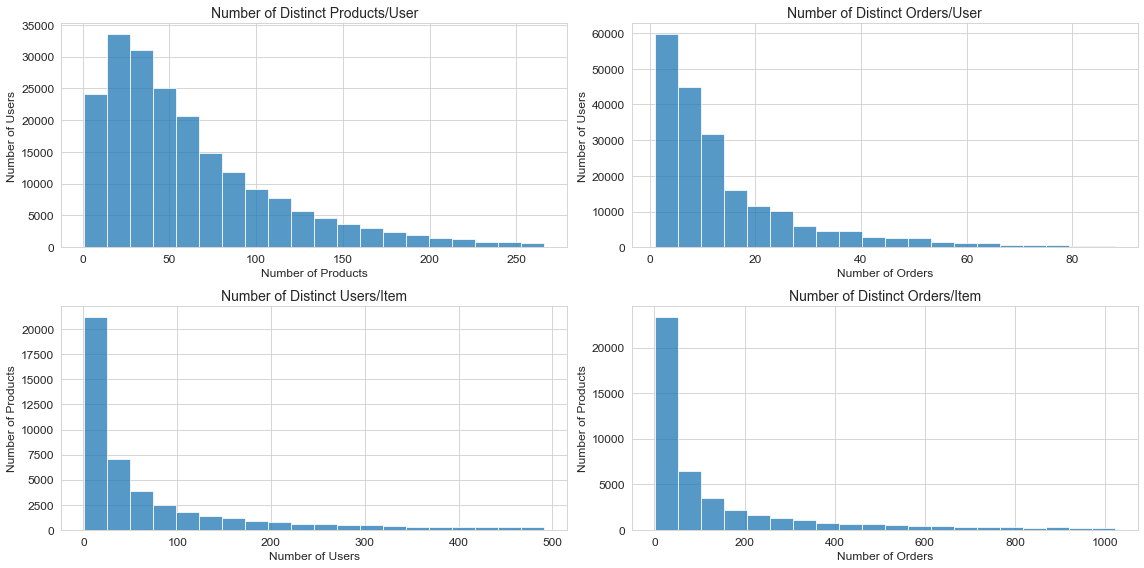

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

range_0 = [1, cnt_item_user.quantile(0.99)]
range_1 = [1, cnt_order_user.quantile(0.99)]
range_2 = [1, cnt_user_item.quantile(0.90)]
range_3 = [1, cnt_order_item.quantile(0.90)]

sns_dist_params = dict(bins=20, hist=True, kde=False, rug=False)
sns.distplot(cnt_item_user,  **sns_dist_params, hist_kws={'range': range_0, 'alpha': 0.75}, ax=axes[0])
sns.distplot(cnt_order_user, **sns_dist_params, hist_kws={'range': range_1, 'alpha': 0.75}, ax=axes[1])
sns.distplot(cnt_user_item,  **sns_dist_params, hist_kws={'range': range_2, 'alpha': 0.75}, ax=axes[2])
sns.distplot(cnt_order_item, **sns_dist_params, hist_kws={'range': range_3, 'alpha': 0.75}, ax=axes[3])

axes[0].set(title="Number of Distinct Products/User", xlabel='Number of Products', ylabel='Number of Users')
axes[1].set(title="Number of Distinct Orders/User", xlabel='Number of Orders', ylabel='Number of Users')
axes[2].set(title="Number of Distinct Users/Item", xlabel='Number of Users', ylabel='Number of Products')
axes[3].set(title="Number of Distinct Orders/Item", xlabel='Number of Orders', ylabel='Number of Products')

fig.tight_layout()
plt.show()

##### User/Item Re-Purchases

In [24]:
user_item_orders = interactions.groupby(['user_id', 'product_id']).size()
user_item_orders.head()

user_id  product_id
1        196           10
         10258          9
         10326          1
         12427         10
         13032          3
dtype: int64

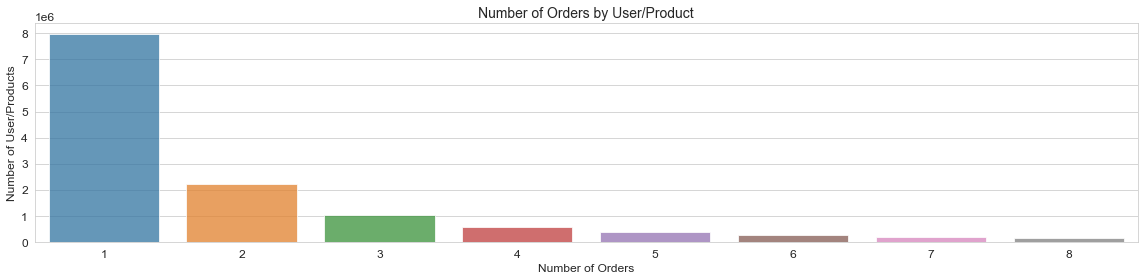

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(16,4))
to_plot = user_item_orders[user_item_orders <= user_item_orders.quantile(0.95)]
sns.countplot(to_plot, alpha=0.75, ax=axes)
axes.set(title='Number of Orders by User/Product', xlabel='Number of Orders', ylabel='Number of User/Products')

fig.tight_layout()
plt.show()

##### Most Popular Items

In [26]:
most_popular_items = cnt_user_item.to_frame('cnt_users').reset_index().sort_values('cnt_users', ascending=False).reset_index(drop=True)
most_popular_items['pct_users'] = most_popular_items['cnt_users'] / n_users
most_popular_items = pd.merge(most_popular_items, products_df, on='product_id', how='inner')
most_popular_items = most_popular_items[['cnt_users', 'pct_users', 'product_id', 'product_name', 'aisle_id', 'department_id']]
most_popular_items.head(10)

,cnt_users,pct_users,product_id,product_name,aisle_id,department_id
0,73956,0.359,24852,Banana,24,4
1,63537,0.308,13176,Bag of Organic Bananas,24,4
2,58838,0.285,21137,Organic Strawberries,24,4
3,55037,0.267,21903,Organic Baby Spinach,123,4
4,46402,0.225,47626,Large Lemon,24,4
5,44859,0.218,26209,Limes,24,4
6,43453,0.211,47209,Organic Hass Avocado,24,4
7,43149,0.209,16797,Strawberries,24,4
8,42771,0.207,47766,Organic Avocado,24,4
9,37138,0.180,39275,Organic Blueberries,123,4


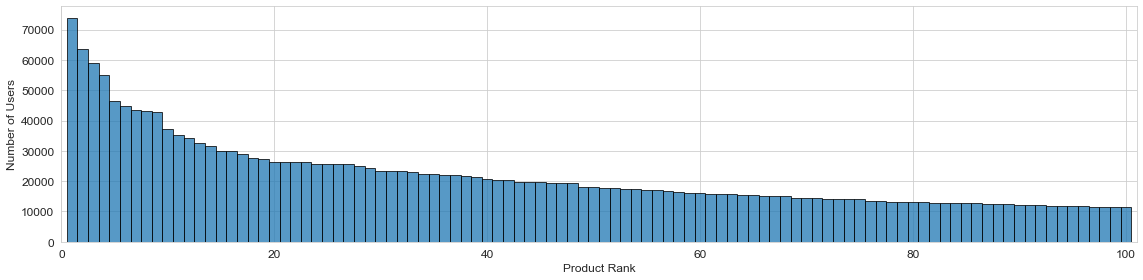

In [27]:
N = 100
to_plot = most_popular_items[:N]

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.bar(to_plot.index + 1, to_plot.cnt_users, width=1.0, linewidth=1, edgecolor='black', alpha=0.75)
ax.set(xlim=(0, N+1), xlabel='Product Rank', ylabel='Number of Users')
fig.tight_layout()
plt.show()

##### Print Matrix Shapes

In [28]:
print('users:', n_users)
print('items:', n_items)
print('interactions:', interactions.shape)
print('unique user/items pairs:', interactions[['user_id', 'product_id']].drop_duplicates().shape[0])

users: 206209
items: 49677
interactions: (32434489, 3)
unique user/items pairs: 13307953


##### Evaluate User/Item Interaction Sparsity

In [29]:
sparsity = 1 - (interactions[['user_id', 'product_id']].drop_duplicates().shape[0] / (n_users * n_items))
print('full interaction data sparsity: {}'.format(round(100 * sparsity, 2)))

full interaction data sparsity: 99.87


#### Subsample the Data for Initial Testing

##### Take a Random Subsample of Users

In [30]:
all_users = interactions.user_id.unique()
all_items = interactions.product_id.unique()

In [34]:
np.random.seed(1492)
s_users = np.random.choice(all_users, size=10000, replace=False)

##### Get All Interactions for Those Users

In [35]:
s_interactions = interactions[interactions.user_id.isin(s_users)].copy()
s_interactions.shape

(1615071, 3)

In [36]:
s_items = s_interactions.product_id.unique()
s_items.shape

(35321,)

##### Re-Evaluate Cardinality / Sparsity on the Sample

In [37]:
n_s_users = len(s_users)
n_s_items = len(s_items)

print('sample users:', n_s_users)
print('sample items:', n_s_items)
print('sample interactions:', s_interactions.shape)

sample users: 10000
sample items: 35321
sample interactions: (1615071, 3)


In [38]:
s_sparsity = 1 - (s_interactions[['user_id', 'product_id']].drop_duplicates().shape[0] / (n_s_users * n_s_items))
print('sample interaction data sparsity: {}'.format(round(100 * s_sparsity, 2)))                  

sample interaction data sparsity: 99.81


#### Split the Data into Train/Validation sets

##### Randomly Shuffle the Overall Interacxtion Data

In [45]:
# This technique is quite beautiful

shuffle_index = np.arange(len(s_interactions))
np.random.shuffle(shuffle_index)

s_interactions = s_interactions.iloc[shuffle_index]
s_interactions['random'] = np.random.random(size=len(s_interactions))
s_interactions.head()

,user_id,product_id,order_id,random
1541144,9981,20119,1972472,0.513
5819145,37052,13829,932329,0.050
6062453,38594,7483,1274721,0.208
10984775,69597,41387,181461,0.254
19365452,122709,30391,2243784,0.204


##### Split Off 25% to Use for Validation

In [47]:
test_pct = 0.25
train_mask = s_interactions['random'] <   (1 - test_pct)
valid_mask = s_interactions['random'] >=  (1 - test_pct)

interactions_total = s_interactions[['user_id', 'product_id']]
interactions_total = interactions_total.iloc[shuffle_index]

interactions_train = s_interactions[train_mask].groupby(['user_id', 'product_id']).size().to_frame('orders').reset_index()
interactions_valid = s_interactions[valid_mask].groupby(['user_id', 'product_id']).size().to_frame('orders').reset_index()

# sample_weight_train = interactions_train['orders']
# sample_weight_valid = interactions_valid['orders']
sample_weight_train = np.log2(interactions_train['orders'] + 1)
sample_weight_valid = np.log2(interactions_valid['orders'] + 1)

interactions_train = interactions_train[['user_id', 'product_id']]
interactions_valid = interactions_valid[['user_id', 'product_id']]

In [48]:
train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

train_items = np.sort(interactions_train.product_id.unique())
valid_items = np.sort(interactions_valid.product_id.unique())
cold_start_items = set(valid_items) - set(train_items)

item_features_train = item_features[item_features.product_id.isin(train_items)]
item_features_valid = item_features[item_features.product_id.isin(valid_items)]

print("total shape: {}".format(interactions_total.shape))
print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))

print("\ntrain weights shape: {}".format(sample_weight_train.shape))
print("valid weights shape: {}".format(sample_weight_valid.shape))

print("\ntrain users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

print("\ntrain items: {}".format(len(train_items)))
print("valid items: {}".format(len(valid_items)))
print("number of cold-start items: {}".format(len(cold_start_items)))

print("\ntrain item features: {}".format(item_features_train.shape))
print("valid item features: {}".format(item_features_valid.shape))

total shape: (1615071, 2)
train shape: (552798, 2)
valid shape: (261968, 2)

train weights shape: (552798,)
valid weights shape: (261968,)

train users: 10000
valid users: 9943
cold-start users: set()

train items: 33371
valid items: 25264
number of cold-start items: 1950

train item features: (33371, 135)
valid item features: (25264, 135)


#### Test Out Core Package Functionality

##### Initialize the MOdel with Chosen Hyperparameters


In [52]:
%load_ext autoreload
%autoreload 2

from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

In [51]:
model = RankFM(factors=50, loss='warp', max_samples=50, alpha=0.01, learning_rate=0.1, learning_schedule='invscaling')

##### Fit the Model on the Training Data and Profile Computational Performance

In [53]:
%%time
model.fit(interactions_train, sample_weight=sample_weight_train, epochs=30, verbose=True)


training epoch: 0
log likelihood: -283677.46875

training epoch: 1
log likelihood: -278103.90625

training epoch: 2
log likelihood: -269158.4375

training epoch: 3
log likelihood: -260240.265625

training epoch: 4
log likelihood: -253088.484375

training epoch: 5
log likelihood: -246918.359375

training epoch: 6
log likelihood: -242184.984375

training epoch: 7
log likelihood: -238963.125

training epoch: 8
log likelihood: -235991.71875

training epoch: 9
log likelihood: -233865.03125

training epoch: 10
log likelihood: -231755.28125

training epoch: 11
log likelihood: -230088.375

training epoch: 12
log likelihood: -228877.25

training epoch: 13
log likelihood: -227350.15625

training epoch: 14
log likelihood: -226076.765625

training epoch: 15
log likelihood: -224590.53125

training epoch: 16
log likelihood: -224319.625

training epoch: 17
log likelihood: -223470.6875

training epoch: 18
log likelihood: -222655.765625

training epoch: 19
log likelihood: -221906.765625

training epoc

##### Generate Model Scores

In [54]:
%%time
scores = model.predict(interactions_valid, cold_start='nan')

Wall time: 500 ms


##### Generate TopN Recommendations

In [55]:
train_users = pd.Series(interactions_train.user_id.unique())
valid_users = pd.Series(interactions_valid.user_id.unique())
both_users = set(train_users) & set(valid_users)

len(train_users), len(valid_users), len(both_users)

(10000, 9943, 9943)

In [60]:
%%time
valid_recs = model.recommend(valid_users, n_items=10, filter_previous=False, cold_start='nan')

Wall time: 44.7 s


In [61]:
print(valid_recs.shape)
valid_recs.head()

(9943, 10)


,0,1,2,3,4,5,6,7,8,9
33,36107,10032,5782,33129,10957,34254,33894,38400,44234,33198
61,5077,16797,17341,24852,19348,16953,36011,40338,44142,25544
72,21137,38689,27845,24852,16797,21903,45007,13176,6347,30639
76,21333,36107,33198,25146,39132,25466,9623,47141,10957,16696
84,45007,22935,21903,47209,26209,8277,24964,21137,30391,24852


#### Evaluate Model Performance on the Validation Data

##### Specify Number of Recommended Items

In [62]:
k = 10

##### Generate Pure-Popularity Baselines

In [63]:
most_popular = interactions_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

product_id
24852    3345
13176    2918
21137    2563
21903    2529
47209    1994
47626    1949
26209    1919
16797    1854
47766    1831
39275    1585
Name: user_id, dtype: int64

In [65]:
test_user_items = interactions_valid.groupby('user_id')['product_id'].apply(set).to_dict()
test_user_items = {key: val for key, val in test_user_items.items() if key in set(train_users)}

base_hrt = np.mean([int(len(set(most_popular.index) & set(val)) > 0)                       for key, val in test_user_items.items()])
base_pre = np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()])
base_rec = np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()])

In [66]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline hit rate: {:.3f}".format(base_hrt))
print("baseline precision: {:.3f}".format(base_pre))
print("baseline recall: {:.3f}".format(base_rec))

number of test users: 9943
baseline hit rate: 0.602
baseline precision: 0.134
baseline recall: 0.058


##### Generate Model Performance Validation Metrics

In [67]:
%%time
model_hrt = hit_rate(model, interactions_valid, k=k)
model_rnk = reciprocal_rank(model, interactions_valid, k=k)
model_pre = precision(model, interactions_valid, k=k)
model_rec = recall(model, interactions_valid, k=k)

Wall time: 3min 9s


In [68]:
print("model hit rate: {}".format(round(model_hrt, 3)))
print("model reciprocal rank: {}".format(round(model_rnk, 3)))
print("model precision: {}".format(round(model_pre, 3)))
print("model recall: {}".format(round(model_rec, 3)))

model hit rate: 0.788
model reciprocal rank: 0.471
model precision: 0.232
model recall: 0.121


##### Assess the Diversity of Recommendations

In [69]:
model_diversity = diversity(model, interactions_valid, k=k).rename({'item_id': 'product_id'}, axis=1)
model_diversity = pd.merge(model_diversity, products_df, on='product_id', how='inner')
model_diversity = model_diversity[['cnt_users', 'pct_users', 'product_id', 'product_name', 'aisle_id', 'department_id']]
model_diversity.tail(20)

,cnt_users,pct_users,product_id,product_name,aisle_id,department_id
33351,0,0.000,18048,"Pretzel \""Shells\""",107,19
33352,0,0.000,18046,Perfect Size Chocolate Lovers Cake Mix,105,13
33353,0,0.000,18045,"Clean & Refresh Antibacterial Body Wash, Laven...",127,11
33354,0,0.000,18043,Baby Soothing Relief Wash,102,18
33355,0,0.000,18040,"Sun-Ripened, Plump Juicy California Raisins Tu...",45,19
33356,0,0.000,18037,Organic Sprouted Wheat Sesame Bagels,93,3
33357,0,0.000,18035,New Manhattan Whole Coffee Beans,26,7
33358,0,0.000,18034,Mamey,24,4
33359,0,0.000,18033,Marz Ult Blue Cheese,89,13
33360,0,0.000,18029,Soothing Bath Treatment,127,11


In [70]:
coverage = np.mean(model_diversity['cnt_users'] > 0 )
round(coverage, 3)

0.153

In [71]:
nonzero = model_diversity[model_diversity.cnt_users > 0]
entropy = -np.sum(nonzero['pct_users'] * np.log2(nonzero['pct_users']))
round(entropy, 2)

45.38

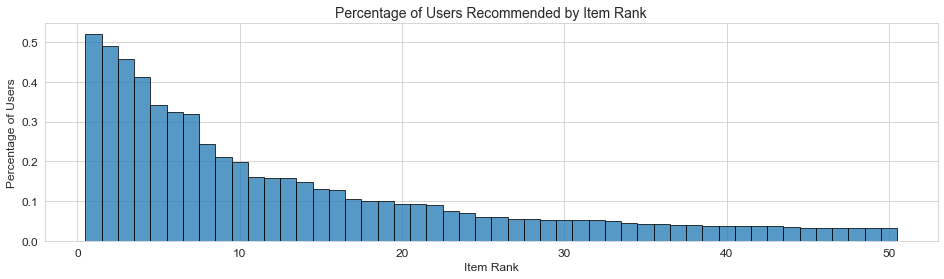

In [72]:
fig, axes = plt.subplots(1, 1, figsize=[16, 4])
N = 50

topN = model_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

##### Get Similar Items for a Few Items

In [78]:
random_user = np.random.choice(valid_users)
print('random user: {}'.format(random_user))

random user: 195940


In [90]:
random_user_recs = valid_recs.loc[random_user]
random_user_recs = products_df[products_df.product_id.isin(random_user_recs)]
random_user_recs

,product_id,product_name,aisle_id,department_id
4136,4137,Whole Grain Oat Cereal,121,14
5076,5077,100% Whole Wheat Bread,112,3
5781,5782,Grade A Large White Eggs,86,16
9075,9076,Blueberries,116,1
16796,16797,Strawberries,24,4
21332,21333,Original Whipped Cream Cheese,108,16
22698,22699,Steamfresh Premium Selects Broccoli Florets,116,1
24851,24852,Banana,24,4
33128,33129,Classic Hummus,67,20
42459,42460,Plain Mini Bagels,93,3


##### Look at Similar Products for a Few of the Random User's Recommended Products

In [91]:
most_similar_items = model.similar_items(48370)
most_similar_items = products_df.set_index('product_id').loc[most_similar_items]
most_similar_items

,product_name,aisle_id,department_id
product_id,,,
14999,Grade A Large Brown Eggs,86,16
15945,Freshly Shredded Parmesan Cheese,21,16
1447,Organic Baby Lettuces,123,4
45698,One Ply Choose A Size Big Roll Paper Towel Rolls,54,17
4136,Living Herbs Potted Living Basil,16,4
41771,Fresh European Style Baby Spinach,123,4
42269,Atlantic Salmon Fillet,39,12
38881,Shredded Iceberg Lettuce,123,4
24750,Organic Whole Fryer Chicken,35,12


#### Assess Model Performance on Novel Item Recommendations

##### Save an Array of the Most Popular Items in the Training Data

In [92]:
most_popular = interactions_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)
print(len(most_popular))
most_popular.head(10)

33371


product_id
24852    3345
13176    2918
21137    2563
21903    2529
47209    1994
47626    1949
26209    1919
16797    1854
47766    1831
39275    1585
Name: user_id, dtype: int64

In [93]:
most_popular = pd.Series(most_popular.index.values)
most_popular[:10]

0    24852
1    13176
2    21137
3    21903
4    47209
5    47626
6    26209
7    16797
8    47766
9    39275
dtype: int64

##### Save the TopK Most Popular Items Not Yet Previously Purchased for Each Customer

In [94]:
# so difficult to me for reproducing code
train_user_items = interactions_train.groupby('user_id')['product_id'].apply(set).to_dict()
train_user_items = {key: val for key, val in test_user_items.items() if key in set(valid_users)}
most_popular_new = {user: most_popular[~most_popular.isin(train_user_items[user])][:k] for user in train_user_items.keys()}
len(most_popular_new)

9943

In [95]:
list(most_popular_new.keys())[:10]

[33, 61, 72, 76, 84, 109, 140, 146, 173, 190]

In [97]:
most_popular_new[140]

0     24852
3     21903
5     47626
8     47766
12    45007
14    49683
16     4605
18     4920
19    31717
20    27104
dtype: int64

##### Calculate the Pure-Popularity Baseline Metrics on Previously Unpurchased Items

In [98]:
base_new_hrt = np.mean([int(len(set(most_popular_new[user]) & set(test_user_items[user])) > 0)                           for user in test_user_items.keys()])
base_new_pre = np.mean([len(set(most_popular_new[user]) & set(test_user_items[user])) / len(set(most_popular_new[user])) for user in test_user_items.keys()])
base_new_rec = np.mean([len(set(most_popular_new[user]) & set(test_user_items[user])) / len(set(test_user_items[user]))  for user in test_user_items.keys()])

In [99]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline new hit rate: {:.3f}".format(base_new_hrt))
print("baseline new precision: {:.3f}".format(base_new_pre))
print("baseline new recall: {:.3f}".format(base_new_rec))

number of test users: 9943
baseline new hit rate: 0.000
baseline new precision: 0.000
baseline new recall: 0.000


##### 

In [100]:
%%time
model_hrt_new = hit_rate(model, interactions_valid, k=k, filter_previous=True)
model_pre_new = precision(model, interactions_valid, k=k, filter_previous=True)
model_rec_new = recall(model, interactions_valid, k=k, filter_previous=True)

Wall time: 2min 23s


##### Calculate Model Performance Excluding Training Items

In [ ]:
%%time
model_hrt_new = hit_rate(model, interactions_valid, k=k, filter_previous=True)
model_pre_new = precision(model, interactions_valid, k=k, filter_previous=True)
model_rec_new = recall(model, interactions_valid, k=k, filter_previous=True)

In [102]:
print("model new hit rate: {}".format(round(model_hrt_new, 3)))
print("model new precision: {}".format(round(model_pre_new, 3)))
print("model new recall: {}".format(round(model_rec_new, 3)))

model new hit rate: 0.337
model new precision: 0.044
model new recall: 0.026


After this procedure , orignally utilizing other methods where is LightFM package , Implicit Package but I didn't deal with these process.